# Idea

We will start with the ~~celebrity~~ (MINST for now!) faces dataset and then go on from there.

Broad idea:
1. Figure out how to get the ~~celebrity~~ images and then noise them.  
    a. This is probably relatively easy to do with pytortch as we can get the ~~celebrity~~ images from there.
    b. Adding noise too should be relatively simple.
    c. We should resize the images, as they are very small for us to be able to just use the 'default' U-net architecture. (There is almost surely a way to make the U-net work for smaller images, but if we stick to the well-known implementation, it also allows for 
    us to widely apply the model for more advanced diffusion tasks)
2. Use an U-net to denoise the image. 
3. Display results. What might be even more cool would be to visualise the denoising and noising process. This should be relatively easy to do. 

# Imports, configuration

In [90]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
import matplotlib.pyplot as plt

In [87]:
# seems to be the standard
T = 1000
# sets up linspace as in the paper
betas = torch.linspace(10**-4,0.02,T)

Note on beta schedule: different approaches exist, but here we just replicate the approach used in [arxiv:2006.11239]

# Dataset initialisation

In [48]:
base_images = datasets.MNIST(
    root="data",
    train=True,
    download="True",
    # resizing images to make them big enough
    transform=Compose([Resize(256),
                       ToTensor()])
)

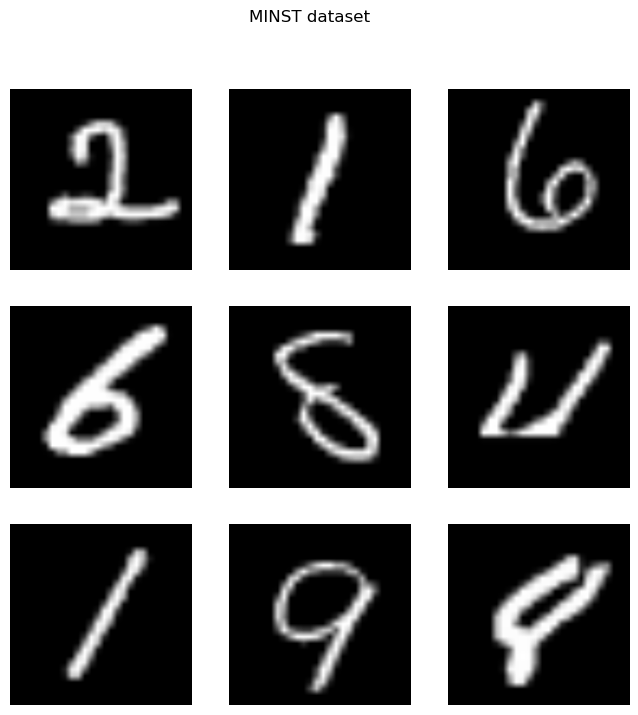

In [49]:
# just a quick plot to visualise the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(base_images), size=(1,)).item()
    img, label = base_images[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
figure.suptitle("MINST dataset")
plt.show()

# Noise addition

Use the gaussian reparameterization trick, we can write $q$ as
\begin{align*}
    q(x_t|x_0)=\mathcal{N}(x_t;\sqrt{\bar{\alpha}}x_0,(1-\hat{\alpha}_t)I)=\sqrt{\bar{\alpha}}x_0+\sqrt{(1-\hat{\alpha}_t)}\epsilon
\end{align*}
where $\epsilon\sim N(0,1)$. This also gives some mathematical intuition behind what is happening. We can for instance notice that as $t$ grows the original image decays further and further until we only have white noise. 

In [53]:
#define epsilon
# we have the dimension (1x256x256), from the definition
eps = torch.normal(0,1,(1,256,256))

# calculate alpha - this could be moved?
alphas = 1-betas

In [54]:
# helper function to add noise
# we could consider checking that image is a suitable type
def add_noise(input_image, t):
    alpha_bar = torch.prod(alphas[:t])
    output = torch.sqrt(alpha_bar)*input_image + torch.sqrt(1-alpha_bar)*eps
    return output

Text(0.5, 0.98, 'MINST dataset, additive noise visualisation')

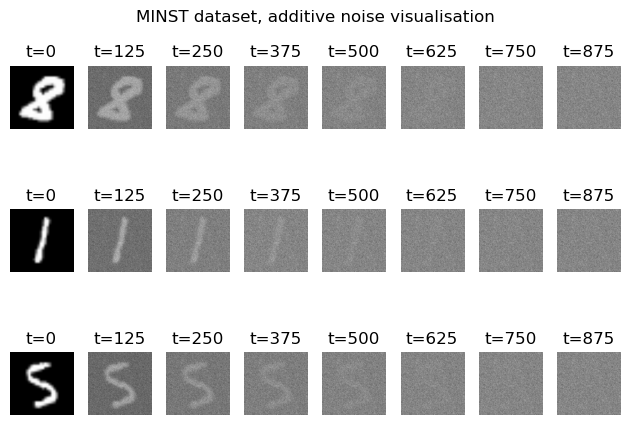

In [ ]:
# allows us to test different time intervals - can be used for visualisation etc.
test_image, l = base_images[0]
x_t = add_noise(test_image, t=1000)

# basically we use the same value for steps and columns - but to make it clearer we do the assignment explicitly
# 6 steps for now
cols, rows = 8,3
steps = np.floor(T/cols)
time_int = torch.arange(0,T,step=steps,dtype=int)

fig, axs = plt.subplots(rows,cols)
for i in range(0,rows):
    sample_idx = torch.randint(len(base_images), size=(1,)).item()
    img, label = base_images[sample_idx]
    for j in range(0,cols):
        # add noise to image stepwise
        noised_image = add_noise(img, time_int[j])
        axs[i,j].imshow(noised_image.squeeze(),cmap="gray")
        axs[i,j].axis('off')
        axs[i,j].set_title(f't={time_int[j]}')
fig.tight_layout()
fig.suptitle("MINST dataset, additive noise visualisation")


# TODO: add more visualisations, noise every image, etc.

# U-net construction, training